In this notebook I extract the scattering layers from an EK80 raw Sv.

In [13]:
import echopype as ep
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
from skimage.filters import threshold_otsu
from skimage import feature
from datetime import datetime

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
sys.path.append("ohw-proj-bioacoustics")
import bioacoustics

# The function

In [3]:
def find_SSL(ds_s,smooth_pings=15, smooth_depth=5):
    """Find layers
    # Algorithm developed by Loïc Bachelot
    
    # Input: 
        ds: xarray from .raw files converted to .nc using echopype, following SONAR-netCDF4 conventions
    # Output: 
        filtered ```
    """
    
    ## Interpolation along DEPTH axis and drop all nan slices in TIME
    ds_s = ds_s.interpolate_na('range_bin', method="linear", fill_value="extrapolate")
    ds_s = ds_s.dropna('ping_time')

    ## Using mean filtering to smooth the image and remove noise
    Sv_smooth = ds_s['Sv'].rolling(ping_time=smooth_pings, center=True).mean().rolling(range_bin=smooth_depth, center=True).mean()
    ds_s = ds_s.assign(variables={"Sv_smooth": (('ping_time', 'range_bin'), Sv_smooth)})

    # Simple thresholding using the mean
    thresh = ds_s['Sv_smooth'].mean()# threshold_otsu(Sv_smooth.data)
    ds_s = ds_s.assign(variables={"Sv_mask": (('ping_time', 'range_bin'), (ds_s['Sv_smooth']>thresh))})

    # Edge detection
    # Using canny filtering to get the edges of the layers
    edges = feature.canny(ds_s['Sv_mask'].data, sigma=11)
    ds_s = ds_s.assign(variables={"edges": (('ping_time', 'range_bin'), edges)})

    filtered = ds_s['Sv'].where(ds_s['Sv_mask'])
    
    return filtered

# Load and convert .nc 
see read_ncEK80 and convert_EK80 notebooks.

In [4]:
# Select date file
nc_path = glob.glob('D:GLIDER2018/Echosounder/Echosounder/nc_files/GLIDER_SB_2018_v5-Phase0-D20180624-T221256-2.nc')

In [5]:
ed = ep.open_converted(nc_path[0])

In [6]:
ds = ep.calibrate.compute_Sv(ed, waveform_mode='BB', encode_mode='complex')

<xarray.DataArray 'gain_correction' (frequency: 1)>
array([48.])
Coordinates:
  * frequency  (frequency) float64 3.33e+05


## Plot the selected file

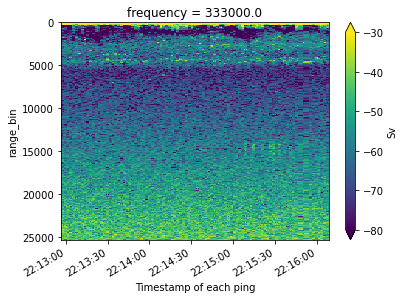

In [16]:
fig = (ds.Sv).plot(x='ping_time', cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

## Select range and time slice
The high range resolution of the broadband files makes it very time consuming for algorithms. Select the supper 50 m, anything below is beyong the noise floor.

In [17]:
# remove nan surface
min_depth_ind = ds.where(ds.range>=1, drop=True).range_bin[0].values

# Find index at 50.5 m depth
max_depth = 50.5
max_depth_ind = ds.where(ds.range>=max_depth, drop=True).range_bin[0].values

In [18]:
ds_subset = ds[['Sv']].isel(frequency=0,range_bin=slice(min_depth_ind,max_depth_ind))


## Plot raw subset

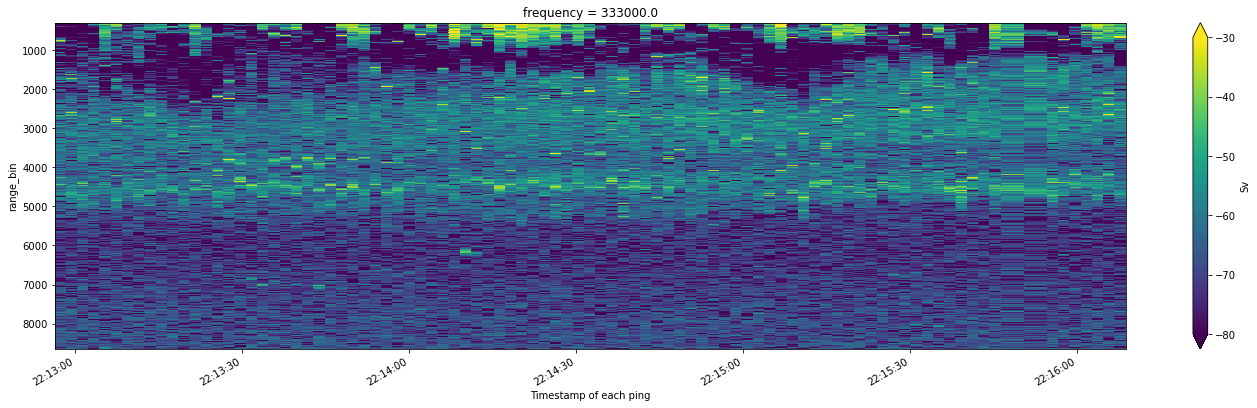

In [19]:
fig = ds_subset.Sv.plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30).figure
plt.gca().invert_yaxis()

In [24]:
filtered = find_SSL(ds_subset,smooth_pings=20, smooth_depth=30)

In [25]:
ds_subset.coords['range_bin']=np.array(ds.range[0,0,min_depth_ind:max_depth_ind]) # replace range bin with depth value/range
filtered.coords['range_bin']=np.array(ds.range[0,0,min_depth_ind:max_depth_ind])

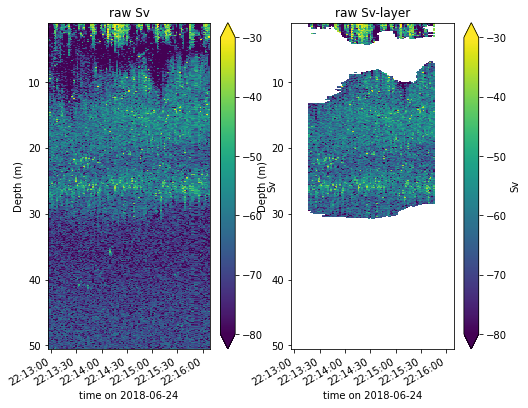

In [26]:
ymd = np.datetime_as_string(ds_subset.ping_time[0].values)[0:10]

fig, ax = plt.subplots(1,2,figsize=(8,6))
ds_subset.Sv.plot(ax = ax[0], x='ping_time',  cmap="viridis", vmin=-80, vmax=-30).figure
ax[0].set_title('raw Sv')
ax[0].set_xlabel(f'time on {ymd}')
ax[0].set_ylabel('Depth (m)')
ax[0].invert_yaxis()


(filtered).plot(ax=ax[1],x='ping_time', cmap="viridis", vmin=-80, vmax=-30).figure
ax[1].set_title('raw Sv-layer')
ax[1].set_ylabel('Depth (m)')
ax[1].set_xlabel(f'time on {ymd}')
ax[1].invert_yaxis()


# run all files and save image

<xarray.DataArray 'gain_correction' (frequency: 1)>
array([48.])
Coordinates:
  * frequency  (frequency) float64 3.33e+05


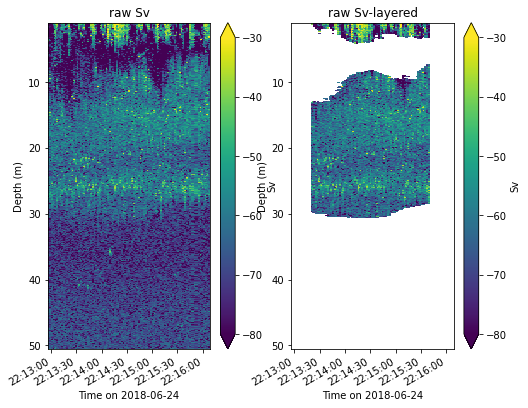

In [28]:
for ind in np.arange(len(nc_path)):
    ed = ep.open_converted(nc_path[ind])
    ds = ep.calibrate.compute_Sv(ed, waveform_mode='BB', encode_mode='complex')
    
    ds_subset = ds[['Sv']].isel(frequency=0,range_bin=slice(min_depth_ind,max_depth_ind))
    
    filtered = find_SSL(ds_subset,smooth_pings=25, smooth_depth=40)
    
    # plotting prep
    ds_subset.coords['range_bin']=np.array(ds.range[0,0,min_depth_ind:max_depth_ind]) # replace range bin with depth value/range
    filtered.coords['range_bin']=np.array(ds.range[0,0,min_depth_ind:max_depth_ind])
    ymd = np.datetime_as_string(ds_subset.ping_time[0].values)[0:10]
    
    # plotting
    fig, ax = plt.subplots(1,2,figsize=(8,6))
    ds_subset.Sv.plot(ax = ax[0], x='ping_time',  cmap="viridis", vmin=-80, vmax=-30).figure
    ax[0].set_title('raw Sv')
    ax[0].set_xlabel(f'Time on {ymd}')
    ax[0].set_ylabel('Depth (m)')
    ax[0].invert_yaxis()

    
    (filtered).plot(ax=ax[1],x='ping_time', cmap="viridis", vmin=-80, vmax=-30).figure
    ax[1].set_title('raw Sv-layered')
    ax[1].set_ylabel('Depth (m)')
    ax[1].set_xlabel(f'Time on {ymd}')
    ax[1].invert_yaxis()
    
    h = np.datetime_as_string(ds_subset.ping_time[0].values)[11:13]
    m = np.datetime_as_string(ds_subset.ping_time[0].values)[14:16]
    
    #fig.savefig(f'./phd/ExtractSSL/figs/filtered-{ymd}-{h}-{m}.png')
    #plt.close()
    plt.show()